# Practical 1: More dogs and cats!

This time, you are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. You will need to adapt the code from lesson 1 to this new task, i.e. a classification with 37 categories.

##  Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
%matplotlib inline

In [2]:
torch.__version__

'2.0.1+cu118'

In [3]:
import sys
sys.version

'3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]'

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Downloading the data

The data given on the website [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) is made of two files: `images.tar.gz` and `annotations.tar.gz`. We first need to download and decompress these files.

Depending if you use google colab or your own computer, you can adapt the code below to choose where to store the data.

To see where you are, you can use the standard unix comands:

In [5]:
%pwd

'/content'

If you want to change to a directory to store your data:

In [6]:
%cd #path

[Errno 2] No such file or directory: '#path'
/content


In [7]:
%pwd

'/content'

In [8]:
%mkdir data
# the line below needs to be adapted if not running on google colab
%cd ./data/

/content/data


Now that you are in the right directory, you can download the data:

In [9]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2023-07-05 09:54:26--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-07-05 09:54:26--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-07-05 09:54:27--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

and uncompress it:

In [10]:
!tar zxvf images.tar.gz
!tar zxvf annotations.tar.gz

流式输出内容被截断，只能显示最后 5000 行内容。
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/tri

Check that everything went correctly!

In [11]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz


## Warning

If you are running this notebook on your own computer, you need to download the data only once. If you want to run this notebook a second time, you can safely skip this section and the section below as your dataset will be stored nicely on your computer.

If you are running this notebook on google colab, you need to download the data and to do the data wrangling each time you are running this notebook as data will be cleared once you log off.

## 1. Exercise: data wrangling

You will first need to do a bit of [data wrangling](https://en.wikipedia.org/wiki/Data_wrangling) to organize your dataset in order to use the PyTorch `dataloader`.

If you want to understand how the files are organized, have a look at the `README` file in the folder `annotations`.

First, we need to split the dataset in a test set and train/validation set. For this, we can use the files `annotations/test.txt` and `annotations/trainval.txt` containing the names of images contained in the test and train/validation sets of the original paper.

In [12]:
!head annotations/test.txt

Abyssinian_201 1 1 1
Abyssinian_202 1 1 1
Abyssinian_204 1 1 1
Abyssinian_205 1 1 1
Abyssinian_206 1 1 1
Abyssinian_207 1 1 1
Abyssinian_20 1 1 1
Abyssinian_210 1 1 1
Abyssinian_212 1 1 1
Abyssinian_213 1 1 1


In [13]:
!head annotations/trainval.txt

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1


Above you see that the authors of the original paper made a partition of the dataset: `./images/Abyssinian_201.jpg` is in the test set while `./images/Abyssinian_100.jpg` is in the train/validation set and so on.

BTW, it you wonder what Abyssinian means, it is explained [here](https://en.wikipedia.org/wiki/Abyssinian_cat)

We first create two directories where we will put images form the test and trainval sets.

In [14]:
%mkdir test
%mkdir trainval

In [15]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz  test/  trainval/


Now it's your turn!

All the images are in the `./images/` folder and you want to store the data according to the following structure:
```bash
.
├── test
|   └── Abyssinian # contains images of Abyssinian from the test set
|   └── Bengal # contains images of Bengal from the test set
|    ...
|   └── american_bulldog # contains images of american bulldog from the test set
|    ...
├── trainval
|   └── Abyssinian # contains images of Abyssinian from the trainval set
|   └── Bengal # contains images of Bengal from the trainval set
|    ...
|   └── american_bulldog # contains images of american bulldog from the trainval set
|    ...
```

Note that all images with a name starting with a majuscule is a cat and all images with a name starting with a minuscule is a dog.

So here is one way to achieve your task: you will read the `./annotations/test.txt` file line by line; from each line, you will extract the name of the corresponding file and then copy it from the `./images/filename_##.jpg` to `./test/filename/filename_##.jpg`, where `##` is a number.

Then you'll do the same thing for `trainval.txt` file.

Below is a little piece of code to show you how to open a file and read it line by line:

In [16]:
with open('./annotations/test.txt') as fp:
    line = fp.readline()
    while line:
        f,_,_,_ = line.split(' ')
        print(f)
        line = fp.readline()
        break

Abyssinian_201


In order to remove the `_201` in the example above, you can use the `re` [regular expression lib](https://docs.python.org/3.6/library/re.html) as follows:

In [17]:
import re
pat = re.compile(r'_\d')
res,_ = pat.split(f)
print(res)

Abyssinian


This small piece of code might be useful:

In [18]:
# create directory if it does not exist
def check_dir(dir_path):
    dir_path = dir_path.replace('//','/')
    os.makedirs(dir_path, exist_ok=True)

Some more hints:
- for moving files around you can use the `shutil` lib, see [here](https://docs.python.org/3.6/library/shutil.html#shutil.copy)
- you can use `os.path.join`
- have a look at python [f-string](https://cito.github.io/blog/f-strings/)

In [19]:
import shutil

In [20]:
#cd images
#%ls
# 为什么Colab上cd进入不用%符号，cd返回上一级就要%符号 答：%是魔术命令，直接执行。正确应该是!cd
#%cd ..

In [21]:
# Here your code for test
# 1. 读取test每一行
# 2. 提取文件名种类名称
# 3. 根据种类名创建新文件夹
# 3. 把图像复制到对应的文件夹下
%cd /content/data
with open('./annotations/test.txt') as fp:
    # 1.读取每一行
    line = fp.readline()
    while line:
        # 2.提取文件名称
        f,_,_,_ = line.split(' ')
        print(f)
        pat = re.compile(r'_\d') # 定义正则表达式
        res,_ = pat.split(f) # 应用到文件名上
        # 3.创建新文件夹
        speices_dir_path = os.path.join('test/', res) # 写相对路径最前面不能有'/'
        # speices_dir_path = '/content/data{}'.format(speices_dir_path) 绝对路径版本
        check_dir(speices_dir_path)
        # 4.复制图像
        src = 'images/{}.jpg'.format(f) # 相对路径即可,先进入images目录查看%ls才知道结构
        print(src)
        shutil.copy(src, speices_dir_path)
        line = fp.readline()
        if line=="": # 退出循环的写法
          break

流式输出内容被截断，只能显示最后 5000 行内容。
Egyptian_Mau_89
images/Egyptian_Mau_89.jpg
Egyptian_Mau_8
images/Egyptian_Mau_8.jpg
Egyptian_Mau_90
images/Egyptian_Mau_90.jpg
Egyptian_Mau_91
images/Egyptian_Mau_91.jpg
Egyptian_Mau_92
images/Egyptian_Mau_92.jpg
Egyptian_Mau_93
images/Egyptian_Mau_93.jpg
Egyptian_Mau_94
images/Egyptian_Mau_94.jpg
Egyptian_Mau_95
images/Egyptian_Mau_95.jpg
Egyptian_Mau_96
images/Egyptian_Mau_96.jpg
Egyptian_Mau_97
images/Egyptian_Mau_97.jpg
Egyptian_Mau_98
images/Egyptian_Mau_98.jpg
Egyptian_Mau_99
images/Egyptian_Mau_99.jpg
Egyptian_Mau_9
images/Egyptian_Mau_9.jpg
english_cocker_spaniel_191
images/english_cocker_spaniel_191.jpg
english_cocker_spaniel_192
images/english_cocker_spaniel_192.jpg
english_cocker_spaniel_193
images/english_cocker_spaniel_193.jpg
english_cocker_spaniel_194
images/english_cocker_spaniel_194.jpg
english_cocker_spaniel_195
images/english_cocker_spaniel_195.jpg
english_cocker_spaniel_196
images/english_cocker_spaniel_196.jpg
english_cocker_spaniel_197
i

In [22]:
#!rm -r -f /content/data/test
#%mkdir /content/data/test

In [23]:
# Here your code for train
%cd /content/data/
with open('./annotations/trainval.txt') as fp: # 打开文件用 with open('')命令
  line = fp.readline() # 读取每一行
  while line:
  # 提取文件名
    f,_,_,_= line.split(' ') #先用split(' ')切分每一行空格
    pat = re.compile(r'_\d') #re.complie定义字符串的正则表达式
    res,_ = pat.split(f) #应用正则表达式
    # 创建新文件夹
    trainval_dir = 'trainval/{}'.format(res)
    check_dir(trainval_dir)
    print(trainval_dir)
    # 复制图像
    src = 'images/{}.jpg'.format(f)
    shutil.copy(src, trainval_dir)
    line = fp.readline()
    if line == "":
      break


/content/data
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainval/Abyssinian
trainv

## Data processing

In [24]:
%cd ..

/content


Now you are ready to redo what we did during lesson 1.

Below, you give the path where the data is stored. If you are running this code on your computer, you should modifiy this cell.

In [25]:
data_dir = '/content/data/'

```datasets``` is a class of the ```torchvision``` package (see [torchvision.datasets](http://pytorch.org/docs/master/torchvision/datasets.html)) and deals with data loading. It integrates a multi-threaded loader that fetches images from the disk, groups them in mini-batches and serves them continously to the GPU right after each _forward_/_backward_ pass through the network.

Images needs a bit of preparation before passing them throught the network. They need to have all the same size $224\times 224 \times 3$ plus some extra formatting done below by the normalize transform (explained later).

In [26]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # 每一个通道的像素点归一化是为了去除亮度的影响

vgg_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

In [27]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), vgg_format)
         for x in ['trainval', 'test']}

In [28]:
os.path.join(data_dir,'trainval')

'/content/data/trainval'

We now have 37 different classes.

In [29]:
dsets['trainval'].classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [30]:
dsets['trainval'].class_to_idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [31]:
dset_sizes = {x: len(dsets[x]) for x in ['trainval', 'test']}
dset_sizes

{'trainval': 3680, 'test': 3669}

In [32]:
dset_classes = dsets['trainval'].classes

The ```torchvision``` packages allows complex pre-processing/transforms of the input data (_e.g._ normalization, cropping, flipping, jittering). A sequence of transforms can be grouped in a pipeline with the help of the ```torchvision.transforms.Compose``` function, see [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html)

In [33]:
loader_train = torch.utils.data.DataLoader(dsets['trainval'], batch_size=32, shuffle=True, num_workers=2)#your code here

In [34]:
loader_valid = torch.utils.data.DataLoader(dsets['test'], batch_size=32, shuffle=False, num_workers=2)#your code here

In [35]:
# num_workers参数指定了用于数据加载的子进程数量，使用多个子进程加载数据有助于提高数据加载的效率，但过高可能造成负载过重

Check your dataloader and everything is doing fine

In [36]:
count = 1
for data in loader_valid:
    print(count, end=',')
    if count == 1:
        inputs_try,labels_try = data
    count += 1

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,

In [37]:
labels_try

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [38]:
inputs_try.shape

torch.Size([32, 3, 224, 224])

A small function to display images:

In [39]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

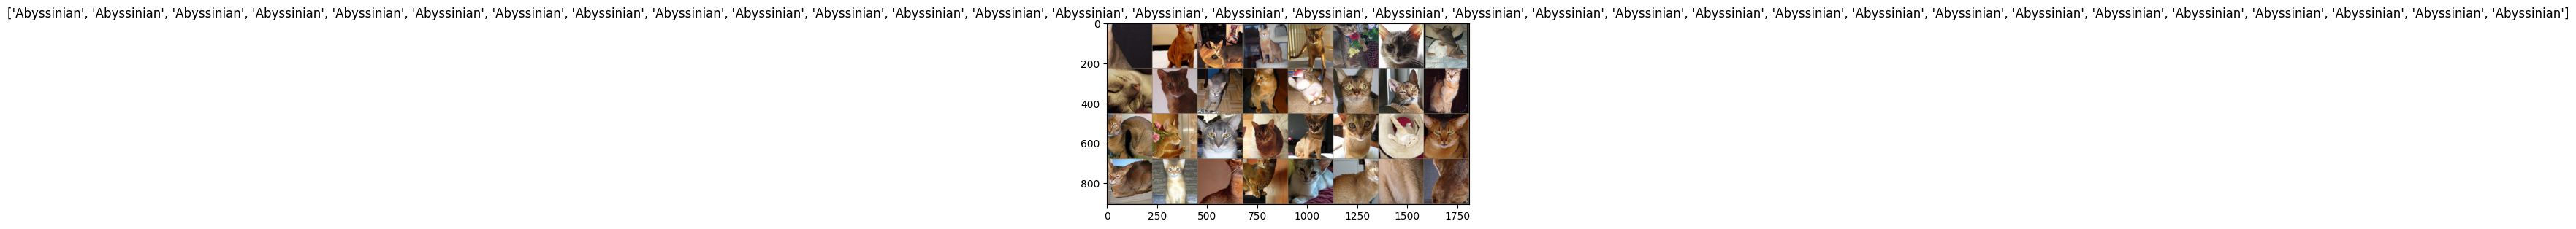

In [40]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

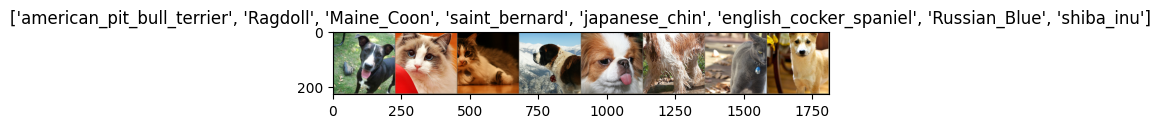

In [41]:
# Get a batch of training data
inputs, classes = next(iter(loader_train))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

## 2. Exercise: modifying VGG Model

The torchvision module comes with a zoo of popular CNN architectures which are already trained on [ImageNet](http://www.image-net.org/) (1.2M training images). When called the first time, if ```pretrained=True``` the model is fetched over the internet and downloaded to ```~/.torch/models```.
For next calls, the model will be directly read from there.

In [42]:
model_vgg = models.vgg16(pretrained=True)#your code here

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 193MB/s]


In [43]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_vgg = model_vgg.to(device)

In [44]:
outputs_try = model_vgg(inputs_try)

In [45]:
outputs_try

tensor([[-1.2660, -2.9953, -2.2004,  ...,  0.6943, -1.4690,  2.3304],
        [-4.9234, -2.5207, -3.0677,  ..., -4.3466, -0.3198,  3.9373],
        [-1.0137,  1.4747, -1.6804,  ..., -2.7671,  3.1500,  2.6378],
        ...,
        [-1.7705, -1.4645, -2.6873,  ..., -3.6004,  1.6712,  5.1645],
        [-2.3779, -3.1313, -2.6874,  ..., -0.7861,  0.6666, -0.6715],
        [-1.5782, -0.8631, -3.0133,  ...,  2.4269,  3.2338, -1.4177]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [46]:
outputs_try.shape

torch.Size([32, 1000])

### Modifying the last layer and setting the gradient false to all layers

In [47]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

![vgg16](https://dataflowr.github.io/notebooks/Module1/img/vgg16.png)

Here, our goal is to use the already trained model and just change the number of output classes. To this end we replace the last ```nn.Linear``` layer trained for 1000 classes to ones with 37 classes. In order to freeze the weights of the other layers during training, we set the field ```required_grad=False```. In this manner no gradient will be computed for them during backprop and hence no update in the weights. Only the weights for the 37-class layer will be updated.

PyTorch documentation for [LogSoftmax](https://pytorch.org/docs/stable/nn.html#logsoftmax)

In [48]:
for param in model_vgg.parameters():
    param.requires_grad = False
# your code here
model_vgg.classifier._modules['6'] = nn.Linear(4096, 37)
# 为了输出概率值
model_vgg.classifier._modules['7'] = torch.nn.LogSoftmax(dim = 1)

In [49]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=37, bias=True)
  (7): LogSoftmax(dim=1)
)


Once you modified the architecture of the network, do not forget to put in onto the device!

In [50]:
# your code here
model_vgg = model_vgg.to(device)

## Training fully connected module

### Creating loss function and optimizer

PyTorch documentation for [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) and the [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [51]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

### Training the model

In [52]:
def train_model(model,dataloader,size,epochs=1,optimizer=None):
    model.train()

    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dataloader:
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [53]:
%%time
train_model(model_vgg,loader_train,size=dset_sizes['trainval'],epochs=2,optimizer=optimizer_vgg)

Loss: 0.0892 Acc: 0.2856
Loss: 0.0550 Acc: 0.6356
CPU times: user 20.6 s, sys: 1.4 s, total: 22 s
Wall time: 45.5 s


In [54]:
def test_model(model,dataloader,size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,37))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    #print(size)
    for inputs,classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,classes)
        _,preds = torch.max(outputs.data,1)
            # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [55]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size=dset_sizes['test'])

Loss: 0.0421 Acc: 0.8226


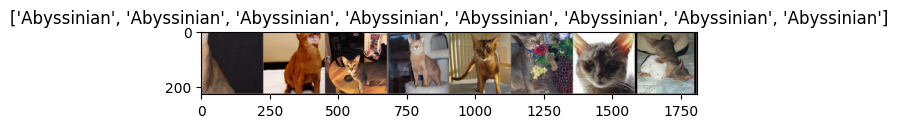

In [56]:
# Get a batch of training data
inputs, classes = next(iter(loader_valid))

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

Compute the predictions made by your network for `inputs[:n_images]` and the associated probabilities.

Hint: use `torch.max` and `torch.exp`.

Do not forget to put your inputs on the device!

In [57]:
# your code here
probs = model_vgg(inputs[:n_images].to(device))
vals_try, preds_try = torch.max(probs, dim=1)# your code here




In [58]:
preds_try # 只预测对了两个...?

tensor([11, 26,  0,  0, 26, 17, 10, 17], device='cuda:0')

In [59]:
classes[:n_images]

tensor([0, 0, 0, 0, 0, 0, 0, 0])

In [60]:
torch.exp(vals_try)

tensor([0.0724, 0.1044, 0.0833, 0.0898, 0.1129, 0.0742, 0.1154, 0.0589],
       device='cuda:0', grad_fn=<ExpBackward0>)

## Speeding up the learning by precomputing features

In [61]:
def preconvfeat(dataloader):
    conv_features = []
    labels_list = []
    for data in dataloader:
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [62]:
%%time
conv_feat_train,labels_train = preconvfeat(loader_train)

CPU times: user 10.2 s, sys: 1.32 s, total: 11.5 s
Wall time: 23.9 s


In [63]:
conv_feat_train.shape

(3680, 512, 7, 7)

In [64]:
%%time
conv_feat_valid,labels_valid = preconvfeat(loader_valid)

CPU times: user 11.2 s, sys: 1.38 s, total: 12.6 s
Wall time: 25 s


### Creating a new data generator

We will not load images anymore, so we need to build our own data loader.

In [65]:
dtype=torch.float
datasetfeat_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_train,labels_train)]
datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_train]
loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=128, shuffle=True)

Now you can train for more epochs.

In [66]:
%%time
train_model(model_vgg.classifier,dataloader=loaderfeat_train,size=dset_sizes['trainval'],epochs=80,optimizer=optimizer_vgg)

Loss: 0.0108 Acc: 0.7372
Loss: 0.0102 Acc: 0.7457
Loss: 0.0096 Acc: 0.7810
Loss: 0.0090 Acc: 0.7856
Loss: 0.0086 Acc: 0.7967
Loss: 0.0082 Acc: 0.7995
Loss: 0.0078 Acc: 0.8065
Loss: 0.0075 Acc: 0.8242
Loss: 0.0072 Acc: 0.8280
Loss: 0.0070 Acc: 0.8302
Loss: 0.0067 Acc: 0.8334
Loss: 0.0065 Acc: 0.8302
Loss: 0.0063 Acc: 0.8451
Loss: 0.0062 Acc: 0.8359
Loss: 0.0060 Acc: 0.8443
Loss: 0.0058 Acc: 0.8462
Loss: 0.0058 Acc: 0.8446
Loss: 0.0056 Acc: 0.8484
Loss: 0.0055 Acc: 0.8543
Loss: 0.0054 Acc: 0.8492
Loss: 0.0054 Acc: 0.8478
Loss: 0.0053 Acc: 0.8576
Loss: 0.0051 Acc: 0.8603
Loss: 0.0050 Acc: 0.8582
Loss: 0.0049 Acc: 0.8584
Loss: 0.0049 Acc: 0.8595
Loss: 0.0048 Acc: 0.8712
Loss: 0.0048 Acc: 0.8611
Loss: 0.0047 Acc: 0.8622
Loss: 0.0047 Acc: 0.8644
Loss: 0.0045 Acc: 0.8715
Loss: 0.0045 Acc: 0.8712
Loss: 0.0043 Acc: 0.8764
Loss: 0.0044 Acc: 0.8736
Loss: 0.0043 Acc: 0.8772
Loss: 0.0043 Acc: 0.8707
Loss: 0.0041 Acc: 0.8796
Loss: 0.0042 Acc: 0.8717
Loss: 0.0041 Acc: 0.8745
Loss: 0.0041 Acc: 0.8769


In [67]:
datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid,labels_valid)]
datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=128, shuffle=False)

Now you can compute the accuracy on the test set.

In [68]:
predictions, all_proba, all_classes = test_model(model_vgg.classifier,dataloader=loaderfeat_valid,size=dset_sizes['test'])

Loss: 0.0034 Acc: 0.8885


## Confusion matrix

For 37 classes, plotting a confusion matrix is useful to see the performance of the algorithm per class.

In [69]:
#!pip install -U scikit-learn

In [70]:
from sklearn.metrics import confusion_matrix
import itertools
def make_fig_cm(cm):
    fig = plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    tick_marks = np.arange(37);
    plt.xticks(tick_marks, dset_classes, rotation=90);
    plt.yticks(tick_marks, dset_classes, rotation=0);
    plt.tight_layout();
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual');
    plt.xlabel('Predicted');

In [71]:
cm = confusion_matrix(all_classes,predictions)

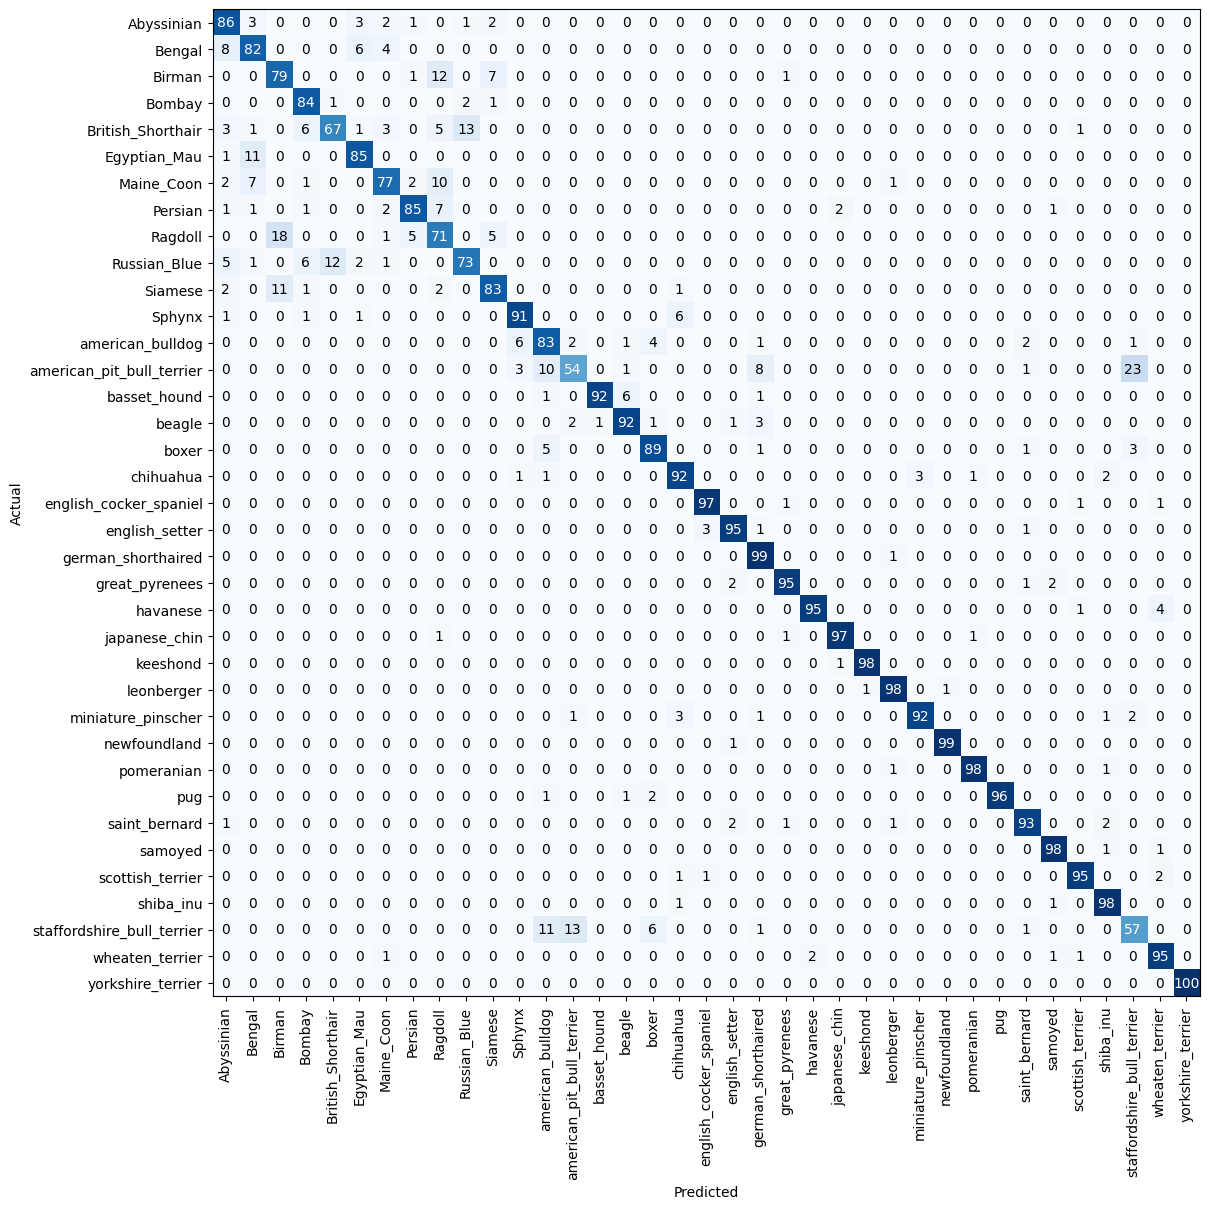

In [72]:
make_fig_cm(cm)

Here, you see that [american pit bull terrier](https://en.wikipedia.org/wiki/American_Pit_Bull_Terrier) are often predicted as [staffordshire bull terrier](https://en.wikipedia.org/wiki/Staffordshire_Bull_Terrier) but overall your algorithm should give pretty good results!

## 3. Exercise: change of neural network model

Great! So far, you reproduced the result of the first lesson. Now, you will need to take another model. I propose to take a `resnet34` from the list availabel [here](https://pytorch.org/docs/stable/torchvision/models.html)

__Note__ the main purpose of this exercise is to lean how to modify a network. We do not really care about performances...

In [73]:
model_resnet = models.resnet34(pretrained=True)# your code here

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 225MB/s]


In [74]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

OK, the strucutre is quite different from the one of VGG we saw during the course but we still see that the last layer is a Linear layer taking a vector of size 512 and producing a vector of size 1000 (i.e. the number of classes in Imagenet). Hence you should be able to modify this network for your classification task with 37 classes!

First freeze the weights of your model and replace the last layer by a Linear layer with the appropriate size.

In [75]:
# your code here
#Hint print(model_resnet.fc) 太贴心了我哭死
for param in model_resnet.parameters():
  param.requires_grad = False
model_resnet.fc = nn.Linear(512, 37)
print(model_resnet.fc)

Linear(in_features=512, out_features=37, bias=True)


Now we need to add the LogSoftmax layer. Follow the instructions [here](https://discuss.pytorch.org/t/how-to-add-an-additional-layer-on-top-of-a-pretrained-model/21303/2) to add this layer

In [82]:
model_resnet_lsm = nn.Sequential(model_resnet, nn.LogSoftmax(dim=1))# your code here 谢谢您帮我写好变量名

Check that everything is working fine!

In [83]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)
model_resnet_lsm = model_resnet_lsm.to(device)
outputs_try = model_resnet_lsm(inputs_try)

In [84]:
outputs_try.shape

torch.Size([32, 37])

Now you can start training.

You will take the same loss as before: [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) but you need to modify the argument of the optimizer [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [ ]:
print(model_resnet_lsm)

In [86]:
#Hint print(model_resnet_lsm[0].fc)
lr = 0.001
optimizer_resnet = torch.optim.SGD(model_resnet_lsm[0].fc.parameters(), lr=lr)#your code here

Now you can use the same function as above for the training loop.

In [87]:
%%time
train_model(model_resnet_lsm,loader_train,size=dset_sizes['trainval'],epochs=30,optimizer=optimizer_resnet)

Loss: 0.1107 Acc: 0.0647
Loss: 0.1003 Acc: 0.1720
Loss: 0.0923 Acc: 0.3177
Loss: 0.0848 Acc: 0.4481
Loss: 0.0782 Acc: 0.5524
Loss: 0.0723 Acc: 0.6122
Loss: 0.0668 Acc: 0.6799
Loss: 0.0620 Acc: 0.7090
Loss: 0.0580 Acc: 0.7375
Loss: 0.0543 Acc: 0.7587
Loss: 0.0510 Acc: 0.7821
Loss: 0.0480 Acc: 0.7897
Loss: 0.0456 Acc: 0.7948
Loss: 0.0432 Acc: 0.8152
Loss: 0.0412 Acc: 0.8163
Loss: 0.0396 Acc: 0.8239
Loss: 0.0380 Acc: 0.8285
Loss: 0.0363 Acc: 0.8337
Loss: 0.0348 Acc: 0.8448
Loss: 0.0338 Acc: 0.8429
Loss: 0.0327 Acc: 0.8467
Loss: 0.0316 Acc: 0.8465
Loss: 0.0305 Acc: 0.8543
Loss: 0.0298 Acc: 0.8541
Loss: 0.0289 Acc: 0.8582
Loss: 0.0281 Acc: 0.8519
Loss: 0.0271 Acc: 0.8641
Loss: 0.0266 Acc: 0.8726
Loss: 0.0261 Acc: 0.8625
Loss: 0.0253 Acc: 0.8739
CPU times: user 1min 54s, sys: 20.7 s, total: 2min 15s
Wall time: 9min 48s


In [88]:
%%time
predictions, all_proba, all_classes = test_model(model_resnet_lsm,loader_valid,size=dset_sizes['test'])

Loss: 0.0260 Acc: 0.8376
CPU times: user 3.84 s, sys: 694 ms, total: 4.53 s
Wall time: 21 s


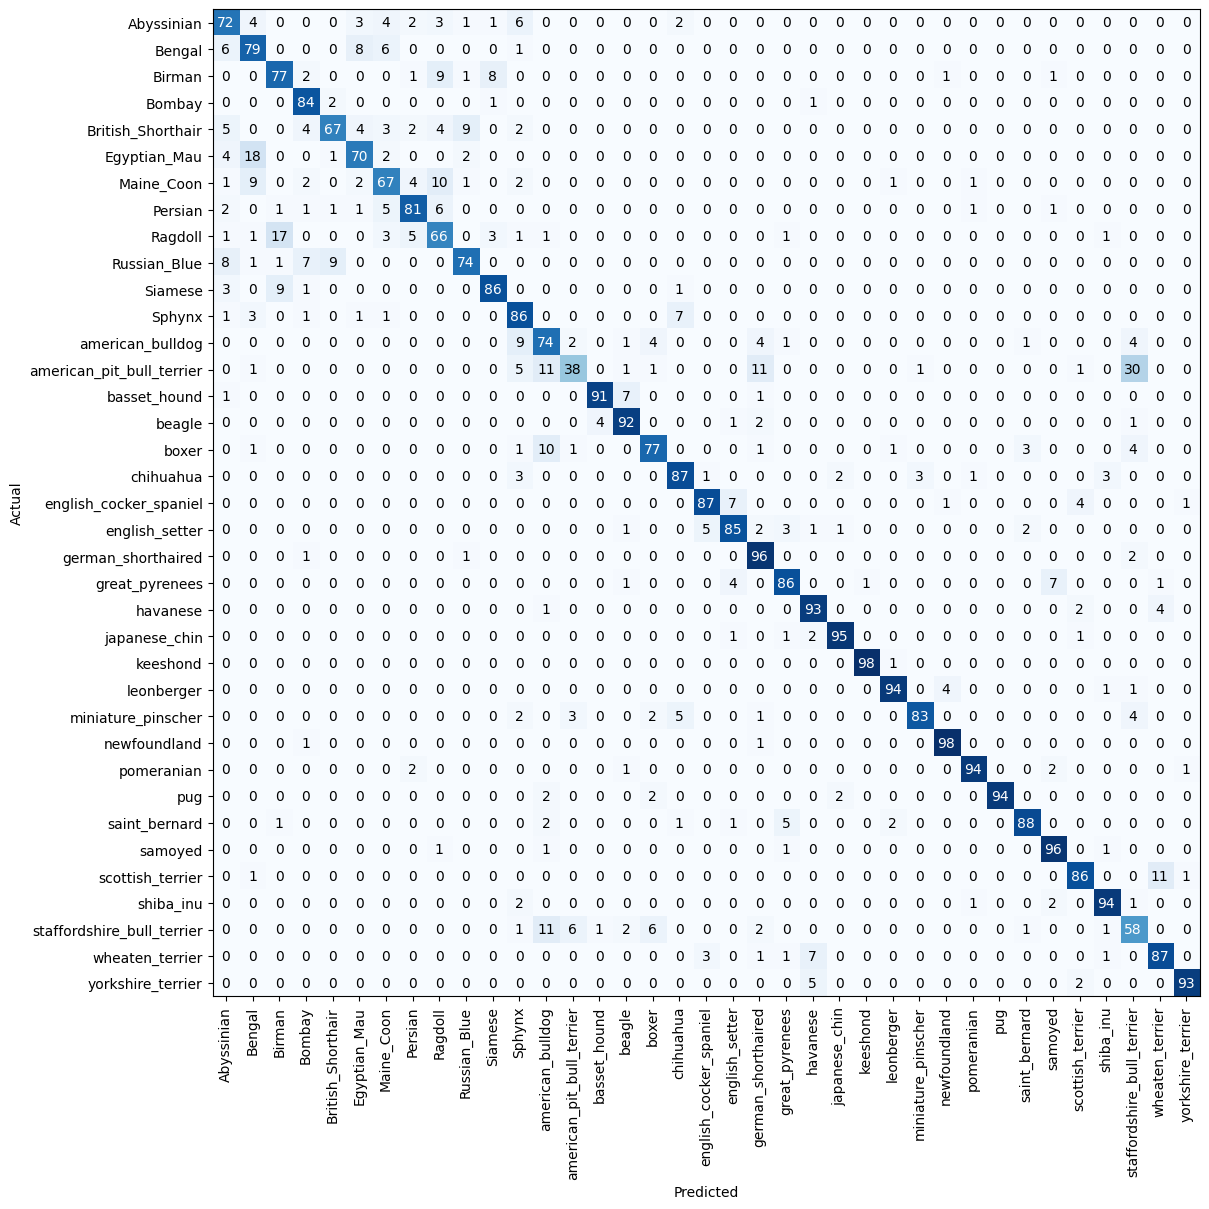

In [89]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

## Well done!

What would you do to speed up the process in the last part?